In [1]:
# !pip3 install wordcloud
# !pip3 install polyglot
# !pip3 install pyicu
# !pip3 install pycld2
# !pip3 install morfessor
# !pip3 install polyglot
# !pip3 install fuzzywuzzy
# !pip3 install seaborn

In [2]:
import os
import pandas as pd
import sys
import numpy as np 
import spacy
import nltk
from nltk import word_tokenize, sent_tokenize, RegexpParser, tree
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz, process

from tqdm import tqdm_notebook, tqdm
from collections import Counter
import re
import operator
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from ast import literal_eval

import string 

## https://markhneedham.com/blog/2017/11/28/python-polyglot-modulenotfounderror-no-module-named-icu/
from polyglot.detect import Detector

tqdm.pandas()

/Users/felisialoukou/.virtualenvs/corona/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/Users/felisialoukou/.virtualenvs/corona/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Load in the survey data

In [4]:
DATA_DIR = "../../data"

survey_filename = os.path.join(DATA_DIR, "uis_20200401_20200409.csv")
df = pd.read_csv(survey_filename)

### Some row duplication present

In [10]:
print(f"rows: {df.shape[0]}\nunique clientIds: {df.intents_clientID.nunique()}")
print(f"unique primary key: {df.primary_key.nunique()}\nunique session_ids: {df.session_id.nunique()}\n")
# print(df.columns)
print(df[df.session_id.isna()].shape)

rows: 61064
unique clientIds: 8030
unique primary key: 10613
unique session_ids: 14062

(2970, 78)


In [11]:
print(df.columns)

Index(['primary_key', 'intents_clientID', 'visitId', 'fullVisitorId',
       'hits_pagePath', 'Started', 'Ended', 'Q1_x', 'Q2_x', 'Q3_x', 'Q4_x',
       'Q5_x', 'Q6_x', 'Q7_x', 'Q8_x', 'session_id', 'dayofweek', 'isWeekend',
       'hour', 'country', 'country_grouping', 'UK_region', 'UK_metro_area',
       'channelGrouping', 'deviceCategory',
       'total_seconds_in_session_across_days',
       'total_pageviews_in_session_across_days', 'finding_count',
       'updates_and_alerts_count', 'news_count', 'decisions_count',
       'speeches_and_statements_count', 'transactions_count',
       'regulation_count', 'guidance_count', 'business_support_count',
       'policy_count', 'consultations_count', 'research_count',
       'statistics_count', 'transparency_data_count',
       'freedom_of_information_releases_count', 'incidents_count',
       'done_page_flag', 'count_client_error', 'count_server_error',
       'ga_visit_start_timestamp', 'ga_visit_end_timestamp',
       'intents_started_da

In [19]:
## the closer these numbers are to # unique primary_key, the better
df.Q3_y.nunique(), df.Q3_x.nunique()

(9601, 9601)

In [20]:
df.drop_duplicates("primary_key", inplace = True)
df.reset_index(inplace=True, drop=True)

## Functions for sentence tokenization, part of speech tagging, PII placeholder stripping, ngram computation

In [21]:
nlp = spacy.load("en_core_web_sm")

pii_filtered = ["DATE_OF_BIRTH", "EMAIL_ADDRESS", "PASSPORT", "PERSON_NAME", 
                "PHONE_NUMBER", "STREET_ADDRESS", "UK_NATIONAL_INSURANCE_NUMBER", "UK_PASSPORT"]
pii_regex = "|".join([f"\\[{p}\\]" for p in pii_filtered])
pii_regex

'\\[DATE_OF_BIRTH\\]|\\[EMAIL_ADDRESS\\]|\\[PASSPORT\\]|\\[PERSON_NAME\\]|\\[PHONE_NUMBER\\]|\\[STREET_ADDRESS\\]|\\[UK_NATIONAL_INSURANCE_NUMBER\\]|\\[UK_PASSPORT\\]'

In [22]:
stop_words = list(stopwords.words('english'))
punctuation = list(string.punctuation) + ['’']
token_blacklist = stop_words + punctuation + pii_filtered

def split_sentences(comment):
    return nltk.sent_tokenize(comment)

def remove_stopwords_punctation(sentences):
    return [[(t[0], t[1], t[2]) for t in sent if t[0].lower() not in token_blacklist] for sent in sentences]

def replace_pii_regex(text):
    return re.sub(pii_regex, "", text)

def compute_ngrams(processed_comment, n, stemming=False, filtering=False):
    # processed_comment = part_of_speech_tag(comment)
    if filtering:
        processed_comment = remove_stopwords_punctation(processed_comment)
    index = 2 if stemming else 0
    tokens = [token[index] for sent in processed_comment for token in sent]
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram).lower() for ngram in ngrams]


def part_of_speech_tag(comment):
    sentences = split_sentences(comment)
    return [[(token.text, token.tag_, token.lemma_) for token in nlp(sentence)] for sentence in sentences]

In [23]:
t = "This is a test with punctuation’. this is another sentence."
processed_t = part_of_speech_tag(t)
compute_ngrams(processed_t, 2, stemming=False, filtering=True)

['test punctuation', 'punctuation another', 'another sentence']

## Detect feedback language
There is a bit of foreign language spam in some responses, detect non (primarily) english comments and drop

In [24]:
def detect_language(text):
    if text!="-":
        try:
            langs = {language.confidence:language.code for language in Detector(text, quiet=True).languages}
            return langs[max(langs.keys())]
        except:
            return f"[ERROR] {text}"
    return "-"

In [25]:
df['Q3_pii_removed'] = df['Q3_x'].progress_map(replace_pii_regex)
df = df[(df.Q3_pii_removed.str.len()<4000)]
df['language'] = df['Q3_pii_removed'].progress_map(detect_language)

  0%|          | 0/10600 [00:00<?, ?it/s]Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the langua

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
 72%|███████▏  | 7631/10600 [00:00<00:00, 11260.23it/s]Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to det

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
100%|██████████| 10600/10600 [00:00<00:00, 11292.85it/s]
/Users/felisialoukou/.virtualenvs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [26]:
lang_dist = df['language'].value_counts().to_dict()
print(f"Number of unique languages: {len(lang_dist)}")
print(f"English: {round((lang_dist['en']*100)/sum(lang_dist.values()), 2)}%")
print(f"-: {round((lang_dist['-']*100)/sum(lang_dist.values()), 2)}%")
list(lang_dist.items())[0:10]

Number of unique languages: 44
English: 90.58%
-: 8.3%


[('en', 9601),
 ('-', 880),
 ('un', 23),
 ('xh', 12),
 ('da', 10),
 ('gv', 9),
 ('gd', 7),
 ('it', 5),
 ('mg', 4),
 ('pl', 4)]

In [27]:
df['is_en'] = df['language'].isin(["en", "un", "-", "sco"])

/Users/felisialoukou/.virtualenvs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
df = df[df['is_en']]
df.shape

(10506, 81)

### Part of speech tag
Run this the first time and save, then just load df

In [30]:
df['pos_tag'] = df[['Q3_pii_removed', 'is_en']].progress_apply(lambda x: part_of_speech_tag(x[0]) 
                                                     if x[1] else [], axis=1)
df['lemmas'] = df['pos_tag'].progress_map(lambda x: [token[2] for sent in x for token in sent])

df['words'] = df['pos_tag'].progress_map(lambda x: [token[0] for sent in x for token in sent])

df.to_csv(os.path.join(DATA_DIR, "uis_20200401_20200409_lang_pos.csv"), index=False)
df = pd.read_csv(os.path.join(DATA_DIR, "uis_20200401_20200409_lang_pos.csv"))
df['pos_tag'] = df['pos_tag'].map(literal_eval)

100%|██████████| 10506/10506 [00:00<00:00, 154942.03it/s]


## Extract noun and verb phrases

In [31]:
part_of_speech_tag(df.Q3_pii_removed.iloc[0])[0][0]

('-', ':', '-')

In [1791]:
grammar = r"""
    cc:
    {<CC>}
    pronoun:
    {<DT><IN><PRP>}
    {<IN>?<PRP>}
    noun_verb:
    {<IN>?<JJ.*>*<NN.*>+<HYPH>?<VBD|VBN|VBG><NN.*>*}
    verb:
    {<IN|TO>*<VB.*><IN|RP|TO>?<RB|WRB|TO>*<IN|TO>*}
    {<MD><VB.*><RB><IN>+}
    {<WRB|WP><TO>?<VB.*>+}
    {<TO><VB><IN>}
    {<TO>?<VB.*><IN|RP>?<WRB|RP|WP>?<IN|TO>?<VB.*>?}
    {<VB.*><TO><VB.*><RB>*<TO>?}
    {<IN><EX><VB.*>}
    {<RB><TO><VB.*>+}
    {<TO>?<VB.*><IN|WDT|WP|RP>}
    {<WP><VB.*>}
    {<VB.*><RB.*>+<VB.*>*<IN|TO>?}
    {<WDT>?<TO>?<MD|VB.*>?<RB>?<TO|IN>?<V.*>+<CC>?<V.*>*<IN|RP>?<IN>*}
    {<MD><RB>*<VB.*>*}
    {<VB.*><IN|TO><IN>*}
    {<TO><VB.*><IN>*}
    {<VB.*>}
    prep_noun:
    {(<CD><IN><DT>)?<IN><JJ.*>*<NN.*>}
    {<IN><NN.*><JJ.*>?<NN.*>+}
    {<IN><NN.*><HYPH>?<NN.*>*}
    {<IN>+<PRP\$>?<NN><CD>?}
    {<IN><CD><.*>}
    {<RB><RBS>?<CD|JJ.*>?<NN.*>+}
    {<RP>?<IN>+<JJ.*>*<NN.*>+}
    {<IN><DT><NN.*><JJ.*>*<NN><HYPH>?<NN>}
    {<IN><NN.*>(<HYPH>?<NN.*>)?}
    {<JJ.*>*<IN><DT>?<NN.*>+<CD>?<NN.*>?}
    {<IN>+<DT>*<JJ>?<CD>?<NN.*>+<CD>?<NN.*>?}
    noun:
    {<CD><NN.*>}
    {<PDT><PRP\$><NN.*>+}
    {<RB><DT>?<JJ.*>*<NN.*>}
    {<DT><HYPH>?<NN.*>}
    {<JJ.*><NN.*>*<CD>}
    {<NN.*><CD><JJ.*>?}
    {<JJ.*|NN.*><IN|TO><PRP>}
    {<CD><NN.*><JJ.*>}
    {<WRB><RB><JJ.*>*<NN.*>*}
    {<DT><JJ.*>*<NN.*>+}
    {<NN.*><CD>?<JJ.*>*<NN.*>*}
    {<IN>+<CD>*<POS>*<IN>*<NN.*>}
    {<IN><PRP\$>?<JJ.*>*<NN.*>}
    {<NN.*><HYPH><NN.*>}
    {<DT>?<CD>?<JJ.*>?<CC>?<JJ.*>?<NN.*>+}
    {<NN.*><HYPH>?<NN.*|JJ.*|VB.*>*}
    {(<NN|NNS>|<NNP|NNPS>)<NNP|NN|NNS|NNPS>+}
    {(<NN|NNS>+|<NNP|NNPS>+)<IN|CC>(<PRP\$|DT><NN|NNS>+|<NNP|NNPS>+)}
    {<JJ|RB|CD>*<NNP|NN|NNS|NNPS>+}
    {<NNP|NN|NNS|NNPS>+}
    {<CD><IN>?<NN.*>}
    adjective:
    {<RB>*<JJ.*><CD>?}
    rb:
    {<RB>+}
    punct:
    {<-RRB->|<-LRB->|<,>|<.>}
    """

class Chunk:

    def __init__(self, label, tokens, indices):
        self.label = label
        self.tokens = tokens
        self.indices = indices
        self.text = self.text()
        self.lemma = self.lemma()
        self.important_lemma = self.important_lemma()
        self.important_word = self.important_word()

    def text(self):
        return " ".join([w for w,  _ , _  in self.tokens])
    
    def lemma(self):
        return " ".join([l for _,  _ , l  in self.tokens])
    
    def tagable_words(self):
        return [(w, pos) for w,  pos , _  in self.tokens if re.search(r"(NN)|(VB)", pos)]
    
    def important_word(self):
        return " ".join([w for w,  pos , _  in self.tokens if re.search(r"(NN)|(VB)|(JJ)|(CD)", pos) ])
    
    def important_lemma(self):
        return " ".join([l for _,  pos , l  in self.tokens if re.search(r"(NN)|(VB)|(JJ)|(CD)", pos) ])
    
parser = RegexpParser(grammar)

def chunk_text(tagged):
    chunks = parser.parse(tagged)
    index = 0
    segments = []
    for el in chunks:
        if type(el) == tree.Tree:
            chunk = Chunk(el.label(), el.leaves(), list(range(index, index + len(el.leaves()))))
            segments.append(chunk)
            index += len(el.leaves())
        else:
            index += 1
    return segments

def extract_phrase(sentences, merge_inplace=False):
    chunks = []
    for sentence in sentences:
        chunks.append(chunk_text(sentence))
    if merge_inplace:
        return [merge_adjacent_chunks(chunk) for chunk in chunks]
    return chunks  

def merge_adjacent_chunks(chunks):
    merged = []
    previous_label = ""
    for chunk in chunks:
        if chunk.label == previous_label and chunk.label != "prep_noun":
            merged[-1] = Chunk(chunk.label, 
                               merged[-1].tokens + chunk.tokens, 
                               merged[-1].indices + chunk.indices)
        else:
            merged.append(chunk)
        previous_label = chunk.label
    return merged

def compute_combinations(sentences, n):
    return [chunks[i:i+n] for chunks in sentences for i in range(len(chunks)-(n-1))]
  

In [1792]:
def extract_wordnet_cats(chunk):
    return [(word, tag, wordnet_category(word, tag)) for  word,tag in chunk.tagable_words()]

## Compute linguistic pattern combinations

In [1793]:
def compute_wordnet_tags_per_chunk(sentences, wordnet_tags):
     for sent in sentences:
        for chunk in sent:
            tagged_words = extract_wordnet_cats(chunk)
            for word,pos,wordnet_tag in tagged_words:
                if wordnet_tag not in wordnet_tags.keys():
                    wordnet_tags[wordnet_tag] = Counter()
                wordnet_tags[wordnet_tag][word.lower()] +=1

def compute_linguistic_patterns(df_series, n):
    pattern_dictionary = {}
    wordnet_tags = {}

    for vals in tqdm_notebook(df_series.values):
        sents = extract_phrase(vals, True)
        compute_wordnet_tags_per_chunk(sents, wordnet_tags)
                            
        for combo in compute_combinations(sents, n):
            key = tuple([c.label for c in combo])
            counter_key =  tuple([c.text.lower() for c in combo])
            
            if key not in pattern_dictionary.keys():
                pattern_dictionary[key]=Counter()

            pattern_dictionary[key][counter_key]+=1
                        
    return pattern_dictionary, wordnet_tags

## Wordnet categorization of individual arguments

In [1794]:
def get_wordnet_pos(pos):
    if pos.startswith("NN"):
        return wn.NOUN
    if pos.startswith("VB"):
        return wn.VERB
    if pos.startswith("RB"):
        return wn.ADV
    if pos.startswith("JJ"):
        return wn.ADJ
    
def wordnet_category(word, pos):
    wn_pos = get_wordnet_pos(pos)
    if re.search("[cCo]((rona)|(vid))", word):
        return "noun.state"
    if len(word.split(" ")) > 1:
        word = word.split(" ")[-1]
    if len(wn.synsets(word, wn_pos))>0 :
        syns = wn.synsets(word, wn_pos)
#         [syn.lexname() for syn in syns]
        return syns[0].lexname()
    return "?"

def bulk_compute_categories(argument_list):
    counter = Counter()
    for argument, counts in argument_list.items():
        wordnet_cat = wordnet_category(argument, "NN")
        if "Tops" in wordnet_cat:
            wordnet_cat = f"noun.{argument.lower().split(' ')[-1]}"
        counter[wordnet_cat] += counts
    return counter

In [1795]:
def wordnet_categories(word, pos):
    wn_pos = get_wordnet_pos(pos)
    if re.search("[cCo]((rona)|(vid))", word):
        return "noun.state"
    if len(word.split(" ")) > 1:
        word = word.split(" ")[-1]
    if len(wn.synsets(word, wn_pos))>0 :
        syns = wn.synsets(word, wn_pos)
#         [syn.lexname() for syn in syns]
        return [syn.lexname() for syn in syns]
    return "?"

## Regular expression matches for themes of interest.
Focusing tagging verbs and tagging second argument component of verbs.

In [1796]:
def regex_for_theme(text):
    if re.search(r"self\s?(-|\s)\s?employ", text.lower()):
        return "self-employ"
    if re.search(r"(deliver(y|(ies)|(ed)))|(slot)|(online shopping)", text.lower()):
        return "delivery"
    if re.search(r"vulnerable", text.lower()):
        return "vulnerable"
    if re.search(r"disab((led)|(ility))", text.lower()):
        return "disabled"
    if re.search(r"no symptom", text.lower()):
        return "no-symptoms"
    if re.search(r"((corona)?(virus))|(covid)", text.lower()):
        return "covid-mention"
    if re.search(r"""((health)|(heart) (problem)|(issue)|(condition)|(attack)|(disease)|(failure))|( ms)|"""+
                 """(copd)|(asthma)|((type)\s?[12])|(diabet)|"""+
                 """(cancer)|(dementia)|(stroke)|(illness)|(a type$)|(cough)|(leukaemia)""", text.lower()):
        return "health-problem"
    if re.search(r"symptom", text.lower()):
        return "symptoms"
    if re.search(r"((at)?(\s(very\s)?high)?\srisk)|(risk list)", text.lower()):
        return "at-risk"
    if re.search(r"""((((a|'|’)m( (in|at)( my)?)?)|aged) (over(-|\s))?"""+
                 """(([789][0-9]($|s|\s))|(old)|(elderly)))|((over(-|\s))?[789][0-9] y)""", text.lower()):
        return "elderly"
    if re.search(r"(carer)|(care home)", text.lower()):
        return "carer"
    if re.search(r"(key\s?(\s|-)?\s?worker)|(nurse($|\s))|(essential worker)", text.lower()):
        return "key-worker"
    if re.search(r"can\s?(no|'|’)?t work", text.lower()):
        return "cannot-work"
    if re.search(r"no ((work)|(income)|(money)|(wage)|(salar))", text.lower()):
        return "no-income"
    if re.search(r"(furlough)|(fired)|(80 %)", text.lower()):
        return "laid-off"
    if re.search(r"""(((can\s?(no|'|’)?t (get|buy|(shop for)))|"""+
                 """((do not)?ha(ve|d) )(no|any|(not enough))?) (food|groceries))""", 
                 text.lower()):
        return "cannot-get-food"
    if re.search(r"can\s?(no|'|’)?t get ((med)|(prescription))", text.lower()):
        return "cannot-get-med"
    if re.search(r"(^med)|(prescription)", text.lower()):
        return "get-med"
    if re.search(r"(travel(\s(advi[sc]e)|(status))?)|(flight)|(destination)", text.lower()):
        return "travel"
    if re.search(r"""(no\s)(\w*\s)?((info)|(clarification)|(advi[sc]e)|((contact )?((details)|(number)))|"""+
                 """(answer)|(update)|(clarity)|(guid(e|(ance)))|(list)|(definition)|"""+
                 """(address)|(link)|(form)|(contact)|(mention))"""
                 , text.lower()):
        return "no-information"
    if re.search(r"""(info)|(clarification)|(advi[sc]e)|((contact )?((details)|(number)))|"""+
                 """(answer)|(update)|(clarity)|(guid(e|(ance)))|(list)|(definition)|"""+
                 """(address)|(link)|(form)|(contact)"""
                 , text.lower()):
        return "information"
    if re.search(r"""(no)\s((letter)|(t(e)?xt)|(message)|(e(\s|(\s?-\s?))?mail)|"""+
                 """(alert)|(notice)|(communication))""", text.lower()):
        return "no-correspondence"
    if re.search(r"(letter)|(t(e)?xt)|(message)|(e(\s|(\s?-\s?))?mail)|(alert)|(notice)", text.lower()):
        return "correspondence"
    if re.search(r"(no\s?((family)|(one)))|(nothing)|(nobody)", text.lower()):
        return "no-one"
    if re.search(r"no ((support)|(aid)|(help)|(assistance)|(access)|(priority))", text.lower()):
        return "no-support"
    if re.search(r"(support)|(aid)|(help)|(assistance)|(access)|(priority)", text.lower()):
        return "support"
    if re.search(r"(child)|((^|\s)son)|(daughter)", text.lower()):
        return "child"
    if re.search(r"""(parent)|(husband)|(wife)|(partner)|"""+
                 """((mo|fa)ther)|(famil(y|(ies)))|(m[uo]m)|(dad)""", text.lower()):
        return "family"
    if re.search(r"(rule)|(restriction)|(measure)|(rights)", text.lower()):
        return "rules"
    if re.search(r"((no)|(a(ny)?)) ((way)|(option)|(choice)|(means)|(idea))", text.lower()):
        return "uncertainty"
    if re.search(r"work ((for)|(in)|(at)|(on))", text.lower()):
        return "work"
    if re.search(r"((self\s|-)?isolat((ion)|(e)|(ing)))|(lock\s?(\s|-)?\s?down)", text.lower()):
        return "self-isolation"
    if re.search(r"(driv(ing|ers)\s)?licen[sc]e", text.lower()):
        return "license"
    if re.search(r"passport", text.lower()):
        return "passport"
    if re.search(r"pension", text.lower()):
        return "pension"
    if re.search(r"(^|\s)h((ome)|(ouse))", text.lower()):
        return "home-mention"
    if re.search(r"(employ)|(work)|(job)|(business)|(company)", text.lower()):
        return "work-mention"
    if re.search(r"(benefit)|(universal credit)|(eligible)|(esa)|(ssp)|(pip)|(allowance)", text.lower()):
        return "benefit"
    if re.search(r"(school)|(student)", text.lower()):
        return "school"
    if re.search(r"(food)|(supplies)|(shopping)|(groceries)", text.lower()):
        return "goods"
    if re.search(r"(money)|(grant)|(fund)|(relief)", text.lower()):
        return "given-money"
    if re.search(r"(bill)|(tax)|(mortgage)|(rent)|(loan)|(debt)|(fine)|(fee)|(insurance)", text.lower()):
        return "bills-to-pay"
    if re.search(r"scheme", text.lower()):
        return "scheme"
    if re.search(r"(^|\s)visa($|\s)", text.lower()):
        return "visa"
    if re.search(r"(data)|(cases)|(situation)|(stat(istic)?s?$)|(status)|(news)|(progress)", text.lower()):
        return "data"
    if re.search(r"dea((th)|d)", text.lower()):
        return "death"
    return "unknown"


In [1797]:
regex_for_theme("stats")

'data'

In [1798]:
def regex_group_verbs(verb):
    if re.search(r"""(f(i|(ou))nd)|(look)|(search)|(clarify)|(ask)|(read)|([ei]nquire)|"""+
                 """(obtain)|(seek)|(know)|((^|\s)see($|\s))|(understand)""", verb):
        return "find-smthg"
    if re.search(r"(access)|(check)|(complete)|(cancel)|(book)|(confirm)", verb):
        return "access-smthg"
    if re.search(r"(get)|(take)|(claim)|(receive)|(sent)|(collect)", verb):
        return "acquire-smthg"
    if re.search(r"(renew)|(change)|(update)|(inform$)|(notify)", verb):
        return "change-smthg"
    if re.search(r"(appl(y|(ied)))|(register)|(qualify)", verb):
        return "apply-smthg"
    if re.search(r"pa(y|(id)|(yed))", verb):
        return "pay-smthg"
    if re.search(r"(contact)|(report)", verb):
        return "contact-smthg"
    if re.search(r"(work)|(employ)", verb):
        return "work-smwhr"
    if re.search(r"(need)|(want)|(require)|(request)|(would like)|(order)", verb):
        return "need-smthg"
    if re.search(r"(have)|((a|'|’|^)m($|\s))|(feel($|\s))", verb):
        return "my-situation"
    if re.search(r"(has)|(((a|we)|'|’|^)re($|\s))", verb):
        return "others-situation"
    if re.search(r"(had)|((i|'|’|^)s($|\s))|(was)", verb):
        return "unclear-situation"
    if re.search(r"travel", verb):
        return "travel"
    if re.search(r"(liv(e|(ing)))|(stay)", verb):
        return "living"
    if re.search(r"(do)|(make)", verb):
        return "do-smthng"
    if re.search(r"go($|\s)", verb):
        return "go-smwhr"
    if re.search(r"(give)|(provide)", verb):
        return "give-smthng"
    if re.search(r"(help)|(protect)|(support)", verb):
        return "help"
    return "unknown"

## Test run code.

In [1799]:
example = df.iloc[7]
example = df[df.Q3_x.str.contains("so obviously")].iloc[0]
print(f"Themetatic category for entire comment: {regex_for_theme(example.Q3_x)}")

print(example.Q3_x)
print()
print(example.pos_tag)
print()
for sent in extract_phrase(example.pos_tag, True):
    for chunk in sent:
        wordnet = extract_wordnet_cats(chunk)
        if len(wordnet) > 0:
            wordnet = wordnet[0][2]
            
        theme = ""
        if chunk.label == "verb":
            theme = regex_group_verbs(chunk.text.lower())
        if chunk.label in ["noun", "prep_noun"]:
            theme = regex_for_theme(chunk.text.lower()) 
            
        print("{0:10} {1:20} {2:15} {3}".format(chunk.label.upper(), chunk.text, theme, chunk.indices))
    print()
    for combo in compute_combinations([sent], 2):
        print(f"{combo[0].text}, {combo[1].text}")
        
#     for combo in compute_combinations([sent], 3):
#         print(f"{combo[0].text}, {combo[1].text}, {combo[2].text}")
    print("=====")

Themetatic category for entire comment: information
For advice about my dog. I don’t have a garden so obviously my dogs needs to go out of the property to toilet. Your instructions seem to ‘assume’ people have gardens.

[[('For', 'IN', 'for'), ('advice', 'NN', 'advice'), ('about', 'IN', 'about'), ('my', 'PRP$', '-PRON-'), ('dog', 'NN', 'dog'), ('.', '.', '.')], [('I', 'PRP', '-PRON-'), ('do', 'VBP', 'do'), ('n’t', 'RB', 'not'), ('have', 'VB', 'have'), ('a', 'DT', 'a'), ('garden', 'NN', 'garden'), ('so', 'RB', 'so'), ('obviously', 'RB', 'obviously'), ('my', 'PRP$', '-PRON-'), ('dogs', 'NNS', 'dog'), ('needs', 'VBZ', 'need'), ('to', 'TO', 'to'), ('go', 'VB', 'go'), ('out', 'IN', 'out'), ('of', 'IN', 'of'), ('the', 'DT', 'the'), ('property', 'NN', 'property'), ('to', 'TO', 'to'), ('toilet', 'VB', 'toilet'), ('.', '.', '.')], [('Your', 'PRP$', '-PRON-'), ('instructions', 'NNS', 'instruction'), ('seem', 'VBP', 'seem'), ('to', 'TO', 'to'), ('‘', '``', "'"), ('assume', 'VB', 'assume'), ('’', 

I have a mother in law who is 90yrs old, lives on her own, has diabetes and asthma, 
so there for self isolating. I am checking on her daily, taking food etc. 
I go there once a week to change her bedding, which she is safely in her conservatory. 
I work for a train company but not in a safety critical role, 
I only serve drinks/snacks, which has been suspended now. 
They want me to come in to clean inside trains ( where the public are) 
and the stations. I have said that I don’t want to come in as caring for my mother in law. They have told me 
that I will have to go off sick and get a sick note from GP? 
Then I will only get statutory sick pay! I don’t want to run the risk 
of infecting my at risk elderly parent. Where do I stand?

## Inspect arg1-arg2 grammatical patterns

In [1800]:
pattern_d, wordnet_tags = compute_linguistic_patterns(df.pos_tag, 2)
pattern_d.keys(), len(pattern_d)

/Users/felisialoukou/.virtualenvs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


(dict_keys([('verb', 'noun'), ('noun', 'adjective'), ('adjective', 'prep_noun'), ('verb', 'adjective'), ('adjective', 'punct'), ('noun', 'prep_noun'), ('prep_noun', 'noun'), ('pronoun', 'verb'), ('prep_noun', 'verb'), ('punct', 'verb'), ('noun', 'cc'), ('cc', 'noun'), ('noun', 'punct'), ('punct', 'rb'), ('rb', 'prep_noun'), ('noun', 'verb'), ('punct', 'pronoun'), ('cc', 'rb'), ('prep_noun', 'adjective'), ('adjective', 'noun'), ('pronoun', 'rb'), ('rb', 'verb'), ('verb', 'punct'), ('verb', 'pronoun'), ('punct', 'noun'), ('punct', 'cc'), ('prep_noun', 'punct'), ('adjective', 'cc'), ('cc', 'verb'), ('rb', 'pronoun'), ('verb', 'prep_noun'), ('pronoun', 'cc'), ('prep_noun', 'prep_noun'), ('noun', 'pronoun'), ('pronoun', 'punct'), ('adjective', 'verb'), ('cc', 'pronoun'), ('adjective', 'pronoun'), ('verb', 'cc'), ('rb', 'adjective'), ('verb', 'noun_verb'), ('noun_verb', 'cc'), ('pronoun', 'noun'), ('noun', 'rb'), ('prep_noun', 'cc'), ('adjective', 'rb'), ('prep_noun', 'pronoun'), ('pronoun',

In [1801]:
patterns_of_interest = [('verb', 'noun'),
('noun', 'prep_noun'),
('prep_noun', 'prep_noun'),
('verb', 'noun_verb'),
('verb', 'prep_noun'),
('noun', 'noun_verb'),
('noun_verb', 'prep_noun')
]

## Compute `arg1` - `arg2` co-occurrence db - couples

In [1802]:
pattern_db = {}

for vals in tqdm_notebook(df.pos_tag.values):
    sents = extract_phrase(vals, True)
    for combo in compute_combinations(sents, 2):
        key = (combo[0].label, combo[1].label)
        arg1 = combo[0].text.lower()
        arg2 = combo[1].text.lower()
#         arg2 = " ".join([w.lower() for w,_ in combo[1].tagable_words()])
        
        if key not in pattern_db.keys():
            pattern_db[key] = {}
        if arg1 not in pattern_db[key].keys():
            pattern_db[key][arg1] = Counter()
            
        pattern_db[key][arg1][arg2]+=1

print(f"There are {len(pattern_db)} possible grammatical combos.")
for i, (k,v) in enumerate(sorted(pattern_db.items(),
                         key = lambda x: len(x[1].values()),
                         reverse= True)[0:15],
                                 1):
    print(k, len(v))

/Users/felisialoukou/.virtualenvs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until



There are 73 possible grammatical combos.
('verb', 'noun') 9341
('noun', 'punct') 4251
('noun', 'prep_noun') 3513
('noun', 'verb') 3435
('verb', 'pronoun') 2649
('verb', 'adjective') 2499
('noun', 'cc') 2352
('prep_noun', 'punct') 2319
('verb', 'punct') 1780
('prep_noun', 'noun') 1594
('noun', 'pronoun') 1556
('prep_noun', 'verb') 1484
('prep_noun', 'prep_noun') 1403
('prep_noun', 'cc') 1064
('noun', 'rb') 1027


In [1803]:
top_100_verbs = [key.lower() for key, value in sorted(pattern_db[('verb', 'noun')].items(), 
                         key = lambda x: sum(x[1].values()), 
                         reverse= True)[0:100]]
counter = 0
for verb in top_100_verbs:
    if regex_group_verbs(verb)== "unknown":
        counter+=1
        print(counter, verb)
        

1 got
2 to tax
3 can
4 came to
5 having
6 driving
7 use
8 regarding
9 says
10 say
11 following
12 to send


In [1804]:
def update_argument_theme_dictionary(dict_new, dict_old):
    for theme, value in dict_new.items():
        if theme not in dict_old.keys():
            dict_old[theme] = Counter()
        for val,count in value.items():
            dict_old[theme][val]+=count

In [1805]:
verb_themes = {}
verb_argument_themes = {}
argument_themes = {}

for pattern in [('verb', 'noun'), ('verb', 'prep_noun')]:
    print(f"There are {len(pattern_db[pattern])} {pattern[0]}s, accompanied by {pattern[1]}s.")
    for i, (arg1, arg2) in enumerate(sorted(pattern_db[pattern].items(),
                             key = lambda x: sum(x[1].values()),
                             reverse= True),
                                     1):
        verb_theme = f"{regex_group_verbs(arg1)}".upper()

        if verb_theme not in verb_themes.keys():
            verb_themes[verb_theme] = Counter()
        
        verb_themes[verb_theme][arg1] += sum(arg2.values())  
        
#         print(f"{i}. {arg1} :: {sum(arg2.values())} [{verb_theme}] \n-----------")
        
        if verb_theme not in verb_argument_themes.keys():
            verb_argument_themes[verb_theme] = {}

        local_themes = {}
        
        for j, (arg2_val, arg2_counts) in enumerate(arg2.items(), 1):
            theme = f"{regex_for_theme(arg2_val)}".upper()
            if theme not in local_themes.keys():
                local_themes[theme] = Counter()
                
            if theme not in argument_themes.keys():   
                argument_themes[theme] = Counter()   
                
            local_themes[theme][arg2_val]+=arg2_counts   
            argument_themes[theme][arg2_val]+=arg2_counts  
            
        update_argument_theme_dictionary(local_themes, verb_argument_themes[verb_theme])
#             print(f"{j}. {arg2_val} : {arg2_counts} [{regex_for_theme(arg1 +' '+arg2_val)}]")
#         for l, (key,value) in enumerate(sorted(local_themes.items(),
#                              key = lambda x: sum(x[1].values()),
#                              reverse= True)[0:10],
#                                      1):
#             print(f"{l}. {key}:: {sum(value.values())}")
#             for argument, count in value.most_common(5):
#                 print(f"{argument}: {count}")
#             print("")
#         print("=======")
        

There are 9341 verbs, accompanied by nouns.
There are 358 verbs, accompanied by prep_nouns.


In [1806]:
len(argument_themes), len(verb_themes)

(44, 19)

In [1807]:
for i, (argument_type, argument_values) in enumerate(sorted(argument_themes.items(),
                             key = lambda x: sum(x[1].values()),
                             reverse= True),
                                     0):
    print(i, argument_type)

0 UNKNOWN
1 INFORMATION
2 WORK-MENTION
3 CORRESPONDENCE
4 SUPPORT
5 DELIVERY
6 HEALTH-PROBLEM
7 BILLS-TO-PAY
8 GOODS
9 COVID-MENTION
10 FAMILY
11 HOME-MENTION
12 VULNERABLE
13 LICENSE
14 GIVEN-MONEY
15 CHILD
16 BENEFIT
17 NO-ONE
18 ELDERLY
19 SELF-ISOLATION
20 DATA
21 NO-INFORMATION
22 UNCERTAINTY
23 PENSION
24 AT-RISK
25 TRAVEL
26 LAID-OFF
27 RULES
28 SCHOOL
29 KEY-WORKER
30 NO-INCOME
31 CARER
32 PASSPORT
33 GET-MED
34 DEATH
35 NO-SUPPORT
36 SYMPTOMS
37 VISA
38 NO-CORRESPONDENCE
39 DISABLED
40 SCHEME
41 SELF-EMPLOY
42 NO-SYMPTOMS
43 WORK


In [1808]:
for i, (verb_type, verb_values) in enumerate(sorted(verb_themes.items(),
                             key = lambda x: sum(x[1].values()),
                             reverse= True),
                                     0):
    print(i, verb_type)    
    for verb_value, count in verb_values.most_common(10):
        print(verb_value, count)

0 UNKNOWN
got 78
to tax 55
can 48
came to 32
having 28
driving 24
use 24
say 22
regarding 21
says 20
1 MY-SITUATION
have 830
am 353
have had 90
'm 54
am in 53
am on 50
do not have 40
’m 33
do n’t have 27
do n't have 26
2 ACQUIRE-SMTHG
to get 335
get 218
received 149
can not get 101
can get 89
have received 65
have not received 65
ca n't get 42
take 40
to claim 39
3 FIND-SMTHG
to find 170
looking for 130
to find out 88
was looking for 57
can not find 54
to see 51
to find out about 46
to look for 43
find 40
to find out if 33
4 UNCLEAR-SITUATION
is 563
had 174
was 76
's 37
is in 37
is on 32
is not 27
was in 26
’s 21
was on 18
5 OTHERS-SITUATION
has 215
are 151
are in 59
has had 23
has been 11
are on 10
re 9
are not 9
were 9
care for 7
6 NEED-SMTHG
need 288
wanted 40
want 31
needs 26
needed 21
would like 17
to order 12
require 10
need to speak to 10
to request 8
7 APPLY-SMTHG
to register 55
to register as 39
to apply for 33
to register for 28
registered 17
apply for 16
register 16
to regis

In [1809]:
for i, (key,value) in enumerate(sorted([(k,v) for k,v in verb_argument_themes.items() if k != "UNKNOWN"],
                                       key = lambda x: sum([sum(counter.values()) for counter in x[1].values()]),
                                      reverse=True),1):

    print(f"{i}. {key} {sum([sum(counter.values()) for counter in value.values()])} {len(value)} \n======")
    for j, (argument, counter) in enumerate(sorted([(k,v) for k,v in value.items() if k != "UNKNOWN"],
                                                   key = lambda x: sum(x[1].values()),
                                                   reverse=True
                                                  )
                                            , 1):

        print(f"{argument}")
        for l, (arg_theme, vals) in enumerate(counter.most_common(5)):
            print(f"{arg_theme}: {vals}")
        print("---")
    print()
            

1. MY-SITUATION 3215 43 
HEALTH-PROBLEM
copd: 42
asthma: 20
diabetes: 15
health problems: 11
cancer: 11
---
INFORMATION
the list: 13
list: 11
the form: 6
details: 4
a number: 3
---
WORK-MENTION
work: 42
a job: 6
an employee: 4
job: 4
2 jobs: 3
---
CORRESPONDENCE
a letter: 48
letter: 7
letters: 4
email: 2
letter.no: 1
---
ELDERLY
77 years: 8
73 years: 8
81 years: 5
80 years: 5
71 years: 5
---
VULNERABLE
a vulnerable person: 26
extremely vulnerable person: 5
the vulnerable list: 4
extremely vulnerable group: 4
the vulnerable category: 3
---
NO-ONE
nothing: 24
no one: 16
no family: 15
nobody shops: 1
nothing other: 1
---
HOME-MENTION
home: 27
housebound: 5
house: 5
the house: 3
home sats: 1
---
FAMILY
husband: 4
a single parent: 4
wife: 3
family: 2
mother: 2
---
NO-INCOME
no income: 21
no money: 14
no work: 5
no wages: 3
no money national insurance number: 1
---
BILLS-TO-PAY
a mortgage: 4
a tax rebate: 4
bills: 3
debt: 2
tax return: 2
---
COVID-MENTION
covid-19: 9
covid 19: 7
the virus: 6

a vulnerable adult: 1
a vulnerable elderly lady: 1
---
NO-SUPPORT
no help: 11
no access: 1
no assistance: 1
no support: 1
---
CHILD
son: 5
daughter: 2
single parent 2 children: 1
granddaughter: 1
the gov.uk/child-maintenance section: 1
---
CARER
carer: 4
a carer: 3
a care home: 2
carer husband: 1
a carer dad: 1
---
SELF-ISOLATION
lockdown: 5
isolation: 2
12 week isolation: 1
14 days isolation: 1
self isolating: 1
---
HOME-MENTION
home: 4
house: 2
staff shortages the homes: 1
houses: 1
the house: 1
---
DELIVERY
deliveries: 3
a delivery slot: 1
1 delivery: 1
food delivery: 1
one delivery: 1
---
GOODS
food: 4
no food: 1
a food parcel a week: 1
a food parcel: 1
food parcel: 1
---
NO-CORRESPONDENCE
no letter: 3
no communication: 2
no email: 1
no message: 1
no email confirmation: 1
---
SCHOOL
students: 2
a student radiographer: 1
a college student: 1
s student: 1
a full time student: 1
---
KEY-WORKER
a key worker: 6
a community nurse: 1
the district nurse: 1
---
BENEFIT
maternity allowance c

email: 1
---
SELF-ISOLATION
the lockdown: 1
isolation note: 1
5 weeks self isolation: 1
---
CHILD
childcare account: 1
the paye login sons company: 1
daughter application: 1
---
VULNERABLE
the vulnerable persons list: 1
extremely vulnerable persons: 1
---
HEALTH-PROBLEM
the public health england: 1
these conditions: 1
---
HOME-MENTION
home: 1
housemate: 1
---
BENEFIT
pip entitlement: 1
ssp: 1
---
DEATH
deaths: 1
death register: 1
---
LAID-OFF
the furlough scheme: 1
80 % grant: 1
---
GIVEN-MONEY
funds: 1
grant: 1
---
SYMPTOMS
symptoms: 1
---
SCHEME
rural payments agency basic payments scheme 2020: 1
---
UNCERTAINTY
any way: 1
---
CARER
carer: 1
---
VISA
the visa: 1
---
AT-RISK
at risk: 1
---
NO-INFORMATION
own with no family contact: 1
---

9. DO-SMTHNG 569 32 
INFORMATION
nhs number: 5
contact: 4
list: 3
form: 2
the list: 2
---
WORK-MENTION
job: 5
work: 4
employees: 3
a good job: 2
business: 2
---
GOODS
shopping: 14
food: 5
food shopping: 2
any shopping: 2
line shopping: 2
---
BILLS-TO

GIVEN-MONEY
money: 1
---
NO-ONE
money nothing: 1
---
DELIVERY
food deliveries: 1
---
DATA
statistics: 1
---
PENSION
pension: 1
---
SELF-EMPLOY
self employment payments: 1
---
SELF-ISOLATION
self isolated problems: 1
---
TRAVEL
travel: 1
---
KEY-WORKER
keyworkers: 1
---

17. GIVE-SMTHNG 95 12 
INFORMATION
details: 6
information: 4
a link: 2
any relevant information: 1
shielding advice: 1
---
SUPPORT
support: 2
priority: 1
access: 1
---
WORK-MENTION
the job: 1
employer: 1
work: 1
---
CORRESPONDENCE
notice: 2
---
GOODS
the public food service: 1
shopping: 1
---
NO-INFORMATION
no information: 1
no guidance: 1
---
BILLS-TO-PAY
the current crisis: 1
feedback: 1
---
FAMILY
husband: 1
the moment: 1
---
CHILD
hours childcare: 1
---
DELIVERY
delivery slots: 1
---
PASSPORT
the passport office reference: 1
---

18. TRAVEL 54 12 
INFORMATION
update: 2
info: 1
---
SUPPORT
assistance: 1
maidstone: 1
---
HOME-MENTION
house: 1
a homes: 1
---
FAMILY
documents mothers funeral: 1
---
WORK-MENTION
company:

## Assign themes to actions and things people are talking about 
### Tag response comments (Q3) with appropriate themes

In [1810]:
phrase_mentions = []
for vals in tqdm_notebook(df.pos_tag.values):
    sents = extract_phrase(vals, True)
    phrase_mentions.append([])
    for combo in compute_combinations(sents, 2):
        key = (combo[0].label, combo[1].label)
        arg1 = combo[0].text.lower()
        arg2 = combo[1].text.lower()
        
        if key in [('verb', 'noun'), ('verb', 'prep_noun')]:
            mention_theme = f"{regex_group_verbs(arg1)} - {regex_for_theme(arg2)}"
            phrase_mentions[-1].append((key, f"{arg1} {arg2}", mention_theme))
            
df['theme_mentions'] = phrase_mentions       

/Users/felisialoukou/.virtualenvs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [1811]:
df[df['theme_mentions'].str.len()>0].iloc[1].theme_mentions

[(('verb', 'noun'),
  'told to register as a vulnerable person',
  'apply-smthg - vulnerable')]

In [1812]:
df['theme_mentions_list'] = df['theme_mentions'].map(lambda x: [mention for key,_, mention in x])

In [1813]:
df['phrases'] = df['theme_mentions'].map(lambda x: [phrase for _,phrase,_  in x])


In [1814]:
df['not_found_phrase'] = df[['phrases', "Q3_pii_removed"]].apply(lambda x: [phrase for phrase in x[0] 
                                                                        if phrase not in x[1].lower()], axis=1)

In [1815]:
import regex

original = "I have a mother in law who is 90yrs old, lives on her own, has diabetes and asthma, so there for self isolating. I am checking on her daily, taking food etc. I go there once a week to change her bedding, which she is safely in her conservatory. I work for a train company but not in a safety critical role, I only serve drinks/snacks, which has been suspended now. They want me to come in to clean inside trains ( where the public are) and the stations. I have said that I don’t want to come in as caring for my mother in law. They have told me that I will have to go off sick and get a sick note from GP? Then I will only get statutory sick pay! I don’t want to run the risk of infecting my at risk elderly parent. Where do I stand?"
missing = ['only serve drinks snacks']
            
def find_missing(missing, original_text):
    for m in missing:
        print(m)
        result = regex.search(regex.compile('(%s){i<=10}' % m.replace(" ", "")), 
                                            original_text.lower())

        pattern = result.group()
        if len(pattern) - len(m) > 8:
            pattern = regex.search(regex.compile('(%s){i<=20}' % m.replace(" ", "")), 
                                            pattern.lower()).group()
            
#         string_dict = dict(zip([str(i) for i in range(len(pattern))], pattern))
        start = pattern.replace(" ","").index(m[0:2].replace(" ",""))
        end = pattern.replace(" ","").rindex(m[-4:].replace(" ",""))+4
            
        print(pattern[start:end])
        yield {m:pattern.replace(" ","")[start:end]}


In [1869]:
from fuzzysearch import find_near_matches
from fuzzywuzzy import process

large_string = "told to register as a vulnerable person for delivery service for on line shopping"
query_string = "told register as a vulnerable person"

def fuzzy_extract(qs, ls, threshold):
    '''fuzzy matches 'qs' in 'ls' and returns list of 
    tuples of (word,index)
    '''
    results = []
    print(qs)
    for word, _ in process.extractBests(qs, (ls,), score_cutoff=threshold):
        print('word {}'.format(word))
        for match in find_near_matches(qs, word, max_l_dist=5):
            match = word[match.start:match.end]
            print('match {}'.format(match))
            results.append(match)
            
    for r in results:
        if qs.split(" ")[0] in r.split(" ")[0]:
            return {qs:r}
        else:
            print(r)
#             index = ls.find(match)
#             yield {qs:match}

from difflib import SequenceMatcher as SM
from nltk.util import ngrams
import codecs

needle = "told register as a vulnerable person"
hay    = "told to register as a vulnerable person for delivery service for on line shopping"

def find_needle(needle, hay):
    needle_length  = len(needle.split())
    max_sim_val    = 0
    max_sim_string = u""
#     print(needle)
    for ngram in ngrams(hay.split(), needle_length + int(.65*needle_length)):
        hay_ngram = u" ".join(ngram)
        similarity = SM(None, hay_ngram, needle).ratio() 
        if similarity > max_sim_val:
            max_sim_val = similarity
            max_sim_string = hay_ngram
    
    if max_sim_string == "":
        max_sim_string = hay

    tokens = needle.split(" ")
    expression = f"({tokens[0]}).*({tokens[-1]})"
    result = regex.search(expression, max_sim_string)
    
    if result is not None:
        pattern = result.group()
#         print(f"needle: [{needle}]",)
#         print(f"pattern: [{pattern}]")
#         print(f"hay: [{hay}]")
#         print(f"hay: [{max_sim_string}]")
        start = pattern.index(needle[0:2])
        end =  pattern.rindex(needle[-2:].replace(" ",""))+2
        
        return {needle: pattern[start:end]}
    return {needle:None}

print(find_needle(needle, hay))

{'told register as a vulnerable person': 'told to register as a vulnerable person'}


In [1870]:
t1 = "I want to find out many things"
tokens = "to find things".split(" ")
expression = f"({tokens[0]}).*({tokens[-1]})"
regex.search(expression, t1)

<regex.Match object; span=(7, 30), match='to find out many things'>

In [1874]:
dict_wrong = {}
found = []
for not_found, original in tqdm_notebook(df[df['not_found_phrase'].str.\
                            len()>0][['not_found_phrase', 'Q3_pii_removed']].values):

    original = re.sub(r"\(|\)|\[|\]", "", original).lower()
    
    result = [find_needle(re.sub(r"\(|\)|\[|\]", "", nf), original) for nf in not_found]
    found.append(result)
    if None in [value for res in result for value in res.values()]:
#         print("----")
        dict_wrong[original] = []
        for res in result:
            for key, value in res.items():
                if value is None:
#                     print(key," : ",value)
                    dict_wrong[original].append((key,value))

/Users/felisialoukou/.virtualenvs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [1875]:
found[0:10]

[[{'am checking on daily': 'am checking on her daily'},
  {'to change bedding': 'to change her bedding'},
  {'is safely in conservatory': 'is safely in her conservatory'},
  {'serve drinks snacks': 'serve drinks/snacks'},
  {'do n’t want to come in as caring for mother': 'don’t want to come in as caring for my mother'},
  {'do n’t want to run the risk': 'don’t want to run the risk'},
  {'of infecting at risk': 'of infecting my at risk'}],
 [{'to explore methods': 'to explore your methods'}],
 [{'about paying employees': 'about paying my employees'}],
 [{'has 6 month visa': 'has a 6 month visa'}],
 [{'can not get a delivery slot': 'cannot get a delivery slot'}],
 [{'is career': 'is my career'}],
 [{'can not get help a d': 'cannot get help a d'}],
 [{'furloughing all dentists': 'furloughing all dentists'}],
 [{'can not work at the moment': 'cannot work at the moment'}],
 [{'am with diabetes': 'am 73 with diabetes'},
  {'is with a heart condition': 'is 82 with a heart condition'}]]

In [1876]:
df.columns

Index(['primary_key', 'intents_clientID', 'visitId', 'fullVisitorId',
       'hits_pagePath', 'Started', 'Ended', 'Q1_x', 'Q2_x', 'Q3_x', 'Q4_x',
       'Q5_x', 'Q6_x', 'Q7_x', 'Q8_x', 'session_id', 'dayofweek', 'isWeekend',
       'hour', 'country', 'country_grouping', 'UK_region', 'UK_metro_area',
       'channelGrouping', 'deviceCategory',
       'total_seconds_in_session_across_days',
       'total_pageviews_in_session_across_days', 'finding_count',
       'updates_and_alerts_count', 'news_count', 'decisions_count',
       'speeches_and_statements_count', 'transactions_count',
       'regulation_count', 'guidance_count', 'business_support_count',
       'policy_count', 'consultations_count', 'research_count',
       'statistics_count', 'transparency_data_count',
       'freedom_of_information_releases_count', 'incidents_count',
       'done_page_flag', 'count_client_error', 'count_server_error',
       'ga_visit_start_timestamp', 'ga_visit_end_timestamp',
       'intents_started_da

In [1873]:
len(dict_wrong)

93

In [1819]:
df[df['not_found_phrase'].str.len()>0].shape

(3662, 90)

In [ ]:
df['verb_themes'] = df['theme_mentions'].map(lambda x: [mention_type.split(" - ")[0] 
                                                        for _,_, mention_type in x])

In [ ]:
example = df.iloc[0]
print("text:", example.Q3_x)
print("identified verb-based themed mentions:", example.theme_mentions)
print("identified themes:", example.theme_mentions_list)
print("identified themes:", example.verb_themes)

In [ ]:
df['ended_date'] = df['Ended'].map(lambda x: "".join(x.split(" ")[0].split("/")[::-1]))
index = sorted(df['ended_date'].unique())[:-1]

## Build the graph

In [72]:
def fix_index_label(index):
    return f"{index[-2:]}/{index[:2]}"

In [73]:
mention_date = {}
for date, mentions in df[['ended_date', "theme_mentions_list"]].values:
    for mention in mentions:
        if mention not in mention_date.keys():
            mention_date[mention] = Counter()
        mention_date[mention][date] += 1

column_dict = {}
for mention,date_counts in sorted([(k,v) for k,v in mention_date.items() if "unknown" not in k],
                                 key = lambda x: sum(x[1].values()),
                                 reverse=True)[0:30]:
#     if any([mtype in mention for mtype in ["support", "no-income", "help"]]):
        
#         if all([mtype not in mention for mtype in ["acquire", "find"]]):
    if "my-situation" in mention:
        print(mention)
        column_dict[mention] = [date_counts.get(date, 0) for date in index]

maximum_value = max([v for date_counter in [v for k,v in mention_date.items() 
                                            if k in column_dict.keys()] 
                     for v in date_counter.values()])
df2 = pd.DataFrame(column_dict, index=index)
# lines = df2.plot.line(figsize=(20,10))
df2.shape, maximum_value

my-situation - health-problem
my-situation - information
my-situation - work-mention
my-situation - correspondence
my-situation - elderly
my-situation - no-one
my-situation - vulnerable


((9, 7), 51)

In [74]:
import random
def generate_dash(n):
#     , 1, 0.5 dots
    return [(random.randint(2, 8), 0.5) for i in range(n)]

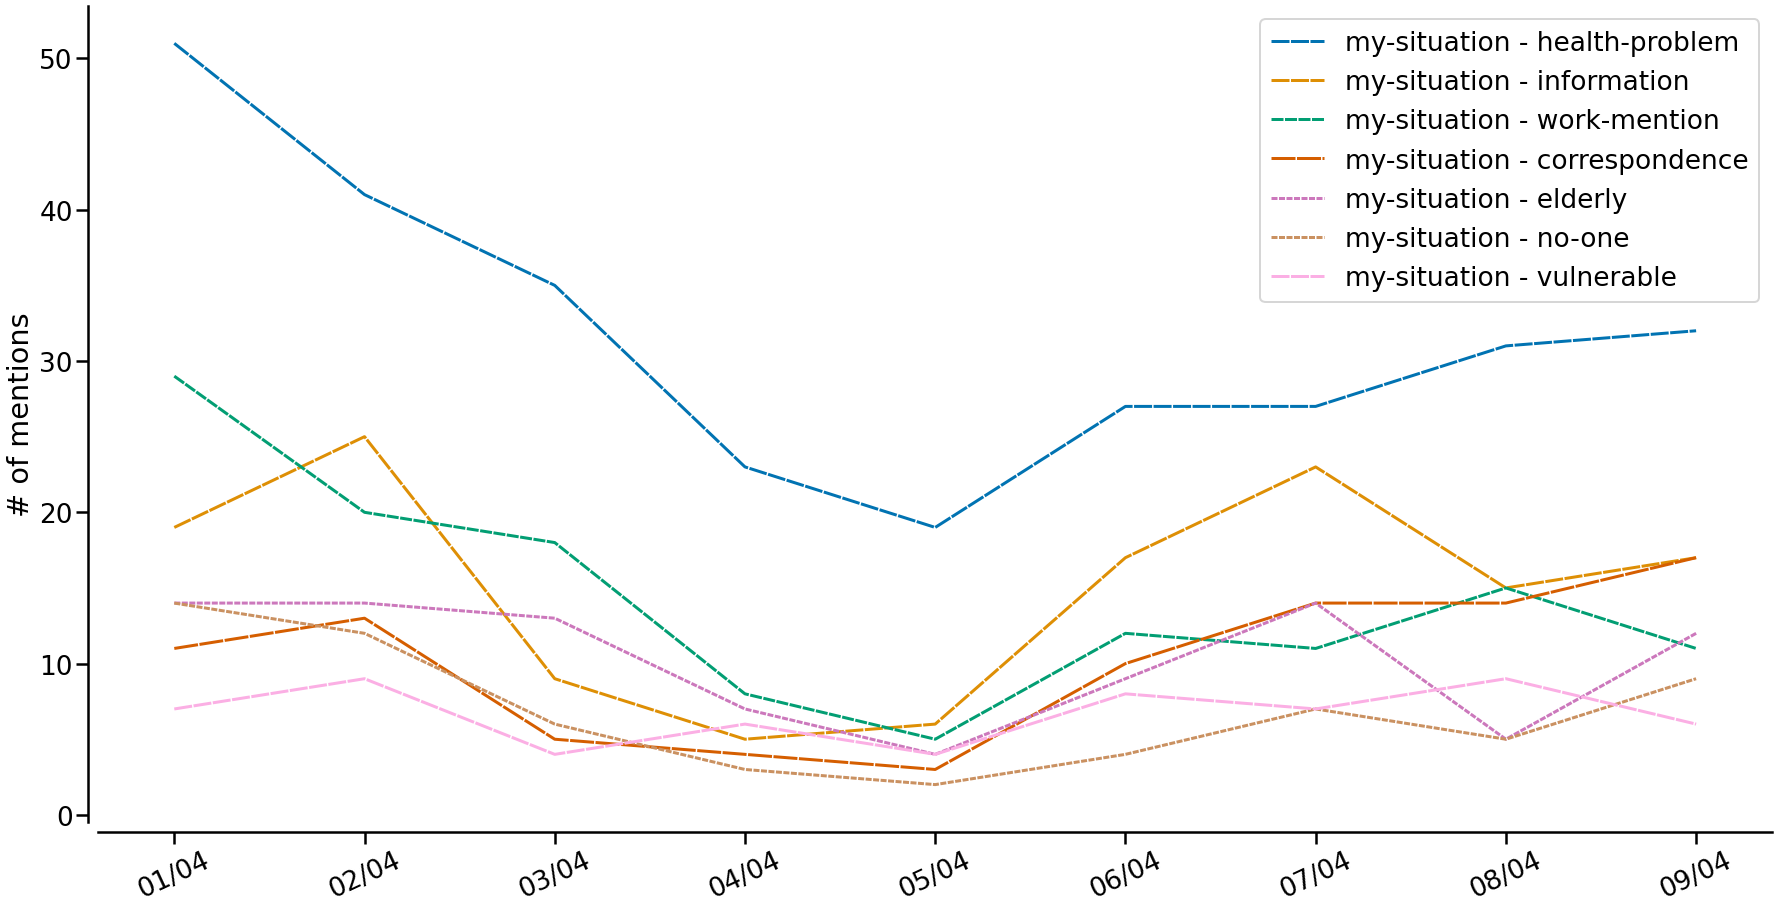

In [75]:
sns.set_context("poster", font_scale=1.2)
plt.figure(figsize=(30, 15))

# ax = sns.lineplot(index, 375, color='black', alpha=0.5)
# ax.lines[0].set_linestyle("--")
# plt.axvline(20200324)

palette = sns.color_palette("colorblind", df2.shape[1])
ax = sns.lineplot(data=df2, palette=palette, dashes= generate_dash(df2.shape[1]))

plt.ylabel(r'# of mentions')
plt.xlabel('')

# plt.yticks(np.arange(0, maximum_value, step=50))

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys(), 
#            bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

sns.despine(offset=10)

labels = [fix_index_label(ind.replace("2020", "")) for ind in index]
ax.set_xticklabels(labels, rotation=25)
plt.savefig(os.path.join(DATA_DIR, "exclude_info.png"), bbox_inches='tight')
plt.show()